In [1]:
# - Outlook for multiple classes: for multi-class prediction 
#     use softmax but for multi-label prediction use sigmoid
# - Use aws deep learning instance: 
#     https://docs.aws.amazon.com/dlami/latest/devguide/keras-mxnet.html
# - Use t-SNE to visualize the word embeddings
# - Similarity search by using learned embeddings, i.e. 
#     https://blog.insightdatascience.com/the-unreasonable-effectiveness-of-deep-learning-representations-4ce83fc663cf
#     (especially Spotify Annoy Index)
# - Test out 1d-conv layers vs. stacked LSTM
# - in order to handle arbitrary length input: 
#     (1) remove input_length from embedding layer,
#     (2) batch wise apply pad_sequences to training input

# TODO:
# - multi-label, unbalanced dataset: use class_wheight, etc. (https://blog.mimacom.com/text-classification/, https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras)
# - use CNN before or after LSTM layers
# - use other metrics to assess model quality (recall, confusion matrix, etc.)
# - implement http://www.aclweb.org/anthology/W18-0913
# - implement http://www.aclweb.org/anthology/C16-1229
# - overall good overview: https://realpython.com/python-keras-text-classification/
# - implement parallel conv layers (towers) + globalmaxpooling on input embeddings, then merge

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence 
from keras.layers import LSTM, Embedding, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.utils import get_file
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
import numpy as np
from nltk.corpus import reuters
from sklearn.preprocessing import MultiLabelBinarizer

MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LEN = 500

Using TensorFlow backend.


In [2]:
#top_categories = [cat for cat, _ in categs[2:7]]
#fileids = reuters.fileids(categories=top_categories)
fileids = reuters.fileids()
fileids_test = np.array([fid for fid in fileids if fid.startswith("test")])
fileids_train = np.array([fid for fid in fileids if fid.startswith("train")])

In [3]:
mlb = MultiLabelBinarizer()
mlb.fit(reuters.categories(fid) for fid in fileids_train)
y_train = mlb.transform(reuters.categories(fid) for fid in fileids_train)
y_test = mlb.transform(reuters.categories(fid) for fid in fileids_test)

In [4]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(reuters.raw(fid) for fid in fileids)
X_train = tokenizer.texts_to_sequences(reuters.raw(fid) for fid in fileids_train)
X_test = tokenizer.texts_to_sequences(reuters.raw(fid) for fid in fileids_test)

In [5]:
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LEN)

In [6]:
# get glove coeff matrix
embeddings_index = {}
fname = get_file("glove.6B.100d.txt", "http://nlp.stanford.edu/data/glove.6B.zip", extract=True)
with open(fname, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

# prepare pre-learned embedding matrix
embdedding_dim = 100
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embdedding_dim))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [7]:
glove_embedding = Embedding(num_words, embdedding_dim, input_length=MAX_SEQUENCE_LEN,
                            embeddings_initializer=Constant(embedding_matrix), trainable=True)

# Build the model 
model = Sequential()
model.add(glove_embedding)
model.add(Dropout(0.1))
model.add(Conv1D(128, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Dropout(0.1))
#model.add(Conv1D(128, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Dropout(0.1))
#model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.1))
#model.add(Dropout(0.1))
#model.add(LSTM(100, return_sequences=True))
#model.add(LSTM(100))
#model.add(Dropout(0.1))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(512, activation='relu', name='fc'))
model.add(Dropout(0.1))
model.add(Dense(mlb.classes_.shape[0], activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          500100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
fc (Dense)                   (None, 512)               66048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__________

In [8]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True)

Train on 6992 samples, validate on 777 samples
Epoch 1/10
6992/6992 [==============================] - 88s 13ms/step - loss: 0.0545 - acc: 0.9845 - val_loss: 0.0271 - val_acc: 0.9926
Epoch 2/10
6992/6992 [==============================] - 119s 17ms/step - loss: 0.0240 - acc: 0.9933 - val_loss: 0.0186 - val_acc: 0.9946
Epoch 3/10
6992/6992 [==============================] - 99s 14ms/step - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0160 - val_acc: 0.9954
Epoch 4/10
6992/6992 [==============================] - 111s 16ms/step - loss: 0.0138 - acc: 0.9956 - val_loss: 0.0134 - val_acc: 0.9960
Epoch 5/10
6992/6992 [==============================] - 94s 13ms/step - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0118 - val_acc: 0.9966
Epoch 6/10
6992/6992 [==============================] - 96s 14ms/step - loss: 0.0092 - acc: 0.9970 - val_loss: 0.0120 - val_acc: 0.9964
Epoch 7/10
6992/6992 [==============================] - 99s 14ms/step - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0111 - val_acc: 0.9969

In [9]:
y_test_pred = model.predict(X_test, verbose=1)

3019/3019 [==============================] - 8s 3ms/step


In [10]:
from sklearn.metrics import classification_report
PRED_THRESHOLD = 0.5
print(classification_report(y_test, y_test_pred>PRED_THRESHOLD, target_names=mlb.classes_))

                 precision    recall  f1-score   support

            acq       0.95      0.97      0.96       719
           alum       1.00      0.52      0.69        23
         barley       1.00      0.29      0.44        14
            bop       0.70      0.63      0.67        30
        carcass       0.89      0.44      0.59        18
     castor-oil       0.00      0.00      0.00         1
          cocoa       1.00      1.00      1.00        18
        coconut       0.00      0.00      0.00         2
    coconut-oil       0.00      0.00      0.00         3
         coffee       0.93      0.96      0.95        28
         copper       0.77      0.56      0.65        18
     copra-cake       0.00      0.00      0.00         1
           corn       0.91      0.91      0.91        56
         cotton       1.00      0.15      0.26        20
     cotton-oil       0.00      0.00      0.00         2
            cpi       0.76      0.57      0.65        28
            cpu       1.00    

/Users/tdiggelm/checkout/total_nn/.py/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tdiggelm/checkout/total_nn/.py/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [13]:
#####################################################################################################################
############################################# TESTING ###############################################################
#####################################################################################################################

In [11]:
from keras.models import Model
model_vec = Model(model.input, model.get_layer(name="fc").output)
vecs = model_vec.predict(X_test, verbose=1)

from sklearn.preprocessing import normalize
vecs_norm = normalize(vecs)

3019/3019 [==============================] - 11s 4ms/step


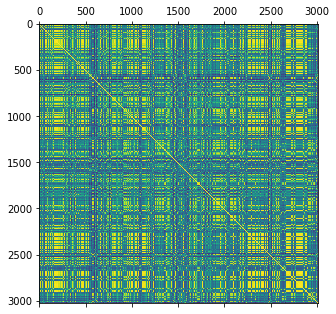

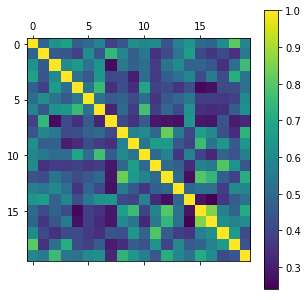

In [12]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

sim_matrix = vecs_norm.dot(vecs_norm.T)

plt.figure(figsize=(5,5))
plt.matshow(sim_matrix, fignum=1)
plt.show()

plt.figure(figsize=(5,5))
plt.matshow(sim_matrix[:20, :20], fignum=1)
plt.colorbar()
plt.show()

In [28]:
search_text = """Taiwan announced plans for another round
  of import tariff cuts on 862 foreign goods shortly before trade
  talks with Washington which officials described as a move to
  help balance trade with the United States."""

#search_text = reuters.raw(fileids_test[300])

#search_text = reuters.raw('test/14842') # gold

print("INPUT:")
print(search_text)

search_text_vec = model_vec.predict(
    sequence.pad_sequences(tokenizer.texts_to_sequences([search_text]), maxlen=MAX_SEQUENCE_LEN))
search_text_vec = normalize(search_text_vec)

print("RESULT:")
sim_scores = search_text_vec[0].dot(vecs_norm.T)
sorted_indices = np.argsort(-sim_scores)
topn = 5
result_scores = sim_scores[sorted_indices[:topn]]
result_tags = [reuters.categories(fid) for fid in fileids_test[sorted_indices[:topn]]]
result_texts = [reuters.raw(fid) for fid in fileids_test[sorted_indices[:topn]]]
for idx in range(topn):
    print(">>> %d: [%0.2f]: %s" % (idx+1, result_scores[idx], ",".join(result_tags[idx])))
    print(result_texts[idx])
    print()

INPUT:
Taiwan announced plans for another round
  of import tariff cuts on 862 foreign goods shortly before trade
  talks with Washington which officials described as a move to
  help balance trade with the United States.
RESULT:
>>> 1: [0.95]: trade
JAPAN GIVEN LITTLE HOPE OF AVOIDING U.S. SANCTIONS
  A top U.S. Official said Japan has little
  chance of persuading the U.S. to drop threatened trade
  sanctions, despite the efforts of a Japanese team that left for
  Washington today.
      Michael Armacost, Under Secretary of State for Political
  Affairs, was asked at a press conference whether Japan's moves
  to boost its domestic economy and open its markets could
  persuade the U.S. Not to impose tariffs on Japanese imports
  said, and replied: "...It is probably too early for the figures
  to demonstrate that the situation has turned around and to
  permit the result you have described."
      Armacost said the U.S. Hopes Japan will take steps to lift
  its domestic economy and re